In [1]:
import numpy as np   # Importo paquete de álgebra lineal
import matplotlib.pyplot as plt   # Importo paquete de gráficos
import math   # Importo paquete de funciones matemáticas
import random   # Importo paquete para generar números pseudoaleatorios
import time

## Punto 1

Se tiene una placa cuadrada de aluminio cuyos bordes están en las condiciones que se indican en la figura: Tres lados a temperaturas fijas y otro, el inferior, aislado térmicamente (flujo de calor igual a cero).
- Encuentre, utilizando el método de diferencias finitas, los valores de temperatura y flujo de calor para cada punto.
- Utilice primero la grilla señalada y luego generalice el problema a un número variable de nodos en cada eje de coordenadas.
- Haga un estudio del tiempo de cálculo en función del tamaño del sistema.

### Resolución

La ecuación diferencial que rige el problema es la ecuación de Laplace, que es la ecuación de transferencia térmica (de Poisson) homogénea:
$$
\frac{\partial^2 T_{(x,y)}}{\partial x^2}+\frac{\partial^2 T_{(x,y)}}{\partial y^2}=0
$$
Debido a que los contornos del recinto donde debemos resolver la ecuación de Laplace son los adecuados, se utiliza el método de DIFERENCIAS FINITAS.

In [2]:
# Defino el tipo de condición de contorno "tipocond" que aplicaré en cada extremo: Puede ser temperatura "Temp" o flujo "Flujo"
TipoCC = {'A':'Temp', 'B':'Flujo', 'C':'Temp', 'D':'Temp'}

# Asigno los valores de las condiciones de contorno "cond".
CC = {'A':75, 'B':0, 'C':50, 'D':100}

**Recordar:**
- Extremo izquierdo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ A
- Extremo inferior $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ B
- Extremo derecho $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ C
- Extremo superior $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ D

### Discretización

Debemos DISCRETIZAR el dominio de la chapa en un conjunto de puntos regularmente distribuidos.
- Divido el eje x en Nx puntos equidistantes, resultando en Nx-1 subintervalos.
- Divido el eje y en Ny puntos equidistantes, resultando en Ny-1 subintervalos.
Se obtiene a una grilla con una cantidad de nodos N = Nx*Ny.

In [3]:
Nx = 100
Ny = 100
N = Nx*Ny

Para asignar valores de temperatura a cada nodo, conviene enumerarlos empleando un único ínidice $k$ así se podrán representar todas las temperaturas en un vector $T$ de Nx*Ny componentes.
Se elige recorrer la grilla desde el extremo izquierdo hacia el extremo derecho, comenzando desde el extremo inferior hasta el extremo superior. Los 4 vértices de la grilla resultan tener las siguientes posiciones:
- Inferior izquierdo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ k = 0
- Inferior derecho $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ k = Nx-1
- Superior izquierdo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ k = (Ny-1)*Nx = N-Nx
- Superior derecho $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ k = (Nx*Ny)-1 = N-1

Según el método de las diferencias finitas, debemos usar las versiones DISCRETAS de las derivadas segundas en la ecuación de Laplace. Se las obtiene planteando el cociente incremental de las derivadas primeras.
- En el eje x, tomando un nodo $k$ que NO se encuentre en el borde de la chapa, tendrá a su izquierda el nodo $k-1$ y a su derecha el nodo $k+1$.
- En el eje y, tomando un nodo $k$ que NO se encuentre en el borde de la chapa, tendrá hacia abajo el nodo $k-Nx$ y hacia arriba el nodo $k+Nx$.

$$
\left. \frac{\partial^2 T}{\partial x^2} \right|_k = \frac{T_{k+1}-2\:T_k+T_{k-1}}{\Delta x^2}
\hspace{1 cm} ; \hspace{1 cm}
\left. \frac{\partial^2 T}{\partial y^2} \right|_k = \frac{T_{k+N_x}-2\:T_k+T_{k-N_y}}{\Delta y^2}
$$

### Matricialización

#### Nodos del interior de la chapa
Reemplazo las expresiones discretizadas de las segundas derivadas parciales en la ecuación de Laplace. Defino $\beta = \frac{\Delta x}{\Delta y}$ y obtengo:

$$
\begin{bmatrix} \beta^2 & 1 & -2(1+\beta^2) & 1 & \beta^2 \end{bmatrix} \:\bullet\: \begin{bmatrix} T_{k-N_x} \\ T_{k-1} \\ T_k \\ T_{k+1} \\ T_{k+N_x} \end{bmatrix} = 0
$$

#### Nodos de los bordes de la chapa
Deben plantearse puntos ficticios por fuera de la grilla, que modifican las expresiones de las primeras derivadas parciales y por ende las de las segundas derivadas parciales.
Reemplazando las nuevas expresiones discretizadas de las segundas derivadas parciales en la ecuación de Laplace, se obtiene:

- Borde izquierdo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm} \begin{bmatrix} \beta^2 & 0 & -2(1+\beta^2) & 2 & \beta^2 \end{bmatrix} $
 
- Borde inferior $\hspace{0.2cm} \rightarrow \hspace{0.2 cm} \begin{bmatrix} 0 & 1 & -2(1+\beta^2) & 1 & 2\:\beta^2 \end{bmatrix} $

- Borde derecho $\hspace{0.2cm} \rightarrow \hspace{0.2 cm} \begin{bmatrix} \beta^2 & 2 & -2(1+\beta^2) & 0 & \beta^2 \end{bmatrix} $

- Borde superior $\hspace{0.2cm} \rightarrow \hspace{0.2 cm} \begin{bmatrix} 2\:\beta^2 & 1 & -2(1+\beta^2) & 1 & 0 \end{bmatrix} $

#### Nodos de los vértices de la chapa
Teniendo en cuenta que los vértices son compartidos entre dos bordes, pueden presentarse tres situaciones:
- Ambos bordes con temperatura fija $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ Se toma una temperatura promedio.
- Un borde con temperatura fija y un borde con flujo de calor fijo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ Se toma la temperatura del primer borde.
- Ambos bordes con flujo de calor fijo $\hspace{0.2cm} \rightarrow \hspace{0.2 cm}$ No se puede resolver el problema.

In [4]:
class chapa:

    def __init__(self, Nx, Ny):
        
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        
        # Defino "beta = Nx/Ny".
        self.beta = Nx/Ny

        # Otra manera de tomar las condiciones de contorno en los BORDES, definiéndolos como vectores.
        self.bordeB = np.linspace(0, self.Nx - 1, self.Nx).astype(int)
        self.bordeD = np.linspace(self.N - self.Nx, self.N - 1, self.Nx).astype(int)
        self.bordeA = np.linspace(0, self.N - self.Nx, self.Ny).astype(int)
        self.bordeC = np.linspace(self.Nx - 1, self.N - 1, self.Ny).astype(int)
        
    def makematrix(self, CC, TipoCC):
        self.CC = CC
        self.TipoCC = TipoCC
        
        # Esto que voy a hacer NO SE HACE, debería cambiar todos los nx, ny y beta de la función por los que llevan self.
        Nx = self.Nx
        Ny = self.Ny
        N = self.N
        beta = self.beta
        
        # Teniendo en cuenta que la matriz tendrá "1" en la diagonal y el resto "0" cuando corresponde a un "k" de borde, 
        # defino la matriz "M" como sigue:
        M = np.eye(N)
        # Defino vector "b" como vector nulo, porque en un problema general la mayoría de las ecuaciones están igualadas a "0",
        # salvo cuando se impone alguna condición de borde.
        b = np.zeros([N, 1])
        
        for k in range(N):
            
            # Vértice inf. izq. (A-B)
            if k==0:
                if self.TipoCC['A']=='Temp' and self.TipoCC['B']=='Flujo':
                    # Dejo el valor de temperatura.
                    b[k] = CC['A']
                elif self.TipoCC['A']=='Flujo' and self.TipoCC['B']=='Temp':
                    # Dejo el valor de temperatura.
                    b[k] = CC['B']
                else:
                    # Ambos bordes tienen temperatura. Hago el promedio.
                    b[k] = (CC['A']+CC['B'])/2
            
            # Vértice inf. der. (B-C)
            elif k==Nx-1:
                if self.TipoCC['B']=='Temp' and self.TipoCC['C']=='Flujo':
                    # Dejo el valor de temperatura.
                    b[k] = CC['B']
                elif self.TipoCC['B']=='Flujo' and self.TipoCC['C']=='Temp':
                    # Dejo el valor de temperatura.
                    b[k] = CC['C']
                else:
                    # Ambos bordes tienen temperatura. Hago el promedio.
                    b[k] = (CC['B']+CC['C'])/2
            
            # Vértice sup. der. (C-D)
            elif k==N-1:
                if self.TipoCC['C']=='Temp' and self.TipoCC['D']=='Flujo':
                    # Dejo el valor de temperatura.
                    b[k] = CC['C']
                elif self.TipoCC['C']=='Flujo' and self.TipoCC['D']=='Temp':
                    # Dejo el valor de temperatura.
                    b[k] = CC['D']
                else:
                    # Ambos bordes tienen temperatura. Hago el promedio.
                    b[k] = (CC['C']+CC['D'])/2
            
            # Vértice sup. izq. (D-A)
            elif k==N-Nx:
                if self.TipoCC['D']=='Temp' and self.TipoCC['A']=='Flujo':
                    # Dejo el valor de temperatura.
                    b[k] = CC['D']
                elif self.TipoCC['D']=='Flujo' and self.TipoCC['A']=='Temp':
                    # Dejo el valor de temperatura.
                    b[k] = CC['A']
                else:
                    # Ambos bordes tienen temperatura. Hago el promedio.
                    b[k] = (CC['D']+CC['A'])/2
            
            # Borde izq. (A)
            elif k%Nx==0:
                if self.TipoCC['A']=='Temp':
                    b[k] = CC['A']
                elif self.TipoCC['A']=='Flujo':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k+1] = 2
                    M[k,k-Nx] = beta**2
                    M[k,k+Nx] = beta**2
            
            # Borde inf. (B)
            elif k<Nx-1:
                if self.TipoCC['B']=='Temp':
                    b[k] = CC['B']
                elif self.TipoCC['B']=='Flujo':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 1
                    M[k,k+1] = 1
                    M[k,k+Nx] = 2*beta**2
            
            # Borde der. (C)
            elif (k+1)%Nx==0:
                if self.TipoCC['C']=='Temp':
                    b[k] = CC['C']
                elif self.TipoCC['C']=='Flujo':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 2
                    M[k,k-Nx] = beta**2
                    M[k,k+Nx] = beta**2
            
            # Borde sup. (D)
            elif k>Nx*(Ny-1)-1:
                if self.TipoCC['D']=='Temp':
                    b[k] = CC['D']
                elif self.TipoCC['D']=='Flujo':
                    M[k,k] = -2*(1+beta**2)
                    M[k,k-1] = 1
                    M[k,k+1] = 1
                    M[k,k-Nx] = 2*beta**2
            
            # Nodos internos
            else:
                M[k,k] = -2*(1+beta**2)
                M[k,k-1] = 1
                M[k,k+1] = 1
                M[k,k-Nx] = beta**2
                M[k,k+Nx] = beta**2
        
        self.M = M
        self.b = b
        return M, b

In [5]:
# Inicializo la chapa.
Chapa = chapa(Nx, Ny)

# Completo la matriz
M, b = Chapa.makematrix(CC, TipoCC)

In [6]:
# Chapa.bordeA

In [7]:
# Chapa.bordeB

In [8]:
# Chapa.bordeC

In [9]:
# Chapa.bordeD

## Solución

In [10]:
# Resuelvo el sistema de ecuaciones "MT=b".
T = np.linalg.solve(M, b)

# Convierto el vector de temperaturas "T" en una matriz de tamaño "Nx*Ny".
T_matriz = T.reshape(Nx, Ny) 

In [11]:
# Configuro el tamaño de los gráficos para que sean más grandes de aquí en adelante.
plt.rc('figure', figsize=(15,8))
plt.rc('font',size=22)

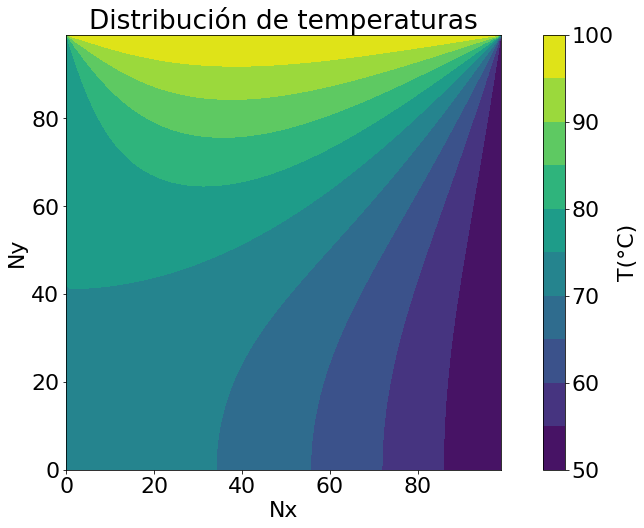

In [12]:
# Defino los niveles de temperatura a graficar, que irán desde la mínima hasta la máxima temperatura almacenadas en "CC".
lvl = np.linspace(50, 100, 11)
mapable = plt.contourf(T_matriz, levels=lvl)
plt.gca().set_aspect('equal')
cbar = plt.colorbar(mapable)
cbar.set_label('T(°C)')
plt.title('Distribución de temperaturas')
plt.xlabel('Nx')
plt.ylabel('Ny')
plt.show()

## Flujos

In [13]:
def getheat(T, dx, dy):
    # El flujo en cada nodo tendrá una componente "x" e "y", por lo que uso "_like" para que me cree vectores "Qx" y "Qy" del
    # mismo tamaño que "T", así podré poner las respectivas componentes en "x" e "y".
    Qx = np.zeros_like(T)
    Qy = np.zeros_like(T)
    N = len(T)
    
    for k in range(N):
        
        # Borde izq. (A)
        if k%Nx==0:
            # Tomo cociente incremental hacia la derecha, ya que para la izquierda no hay nada y no puedo tomar cociente 
            # incremental centrado.
            Qx[k] = (T[k+1]-T[k])/dx
        # Borde der. (C)
        elif (k+1)%Nx==0:
            # Tomo cociente incremental hacia la izquierda, ya que para la derecha no hay nada y no puedo tomar cociente 
            # incremental centrado.
            Qx[k] = (T[k]-T[k-1])/dx
        # Nodos internos y los otros bordes
        else:
            # Tomo cociente incremental centrado, ya que tengo elementos a izquierda y derecha.
            Qx[k] = (T[k+1]-T[k-1])/(2*dx)
            
    for k in range (N):
        
        # Borde inf. (B)
        if k<Nx-1:
            # Tomo cociente incremental hacia arriba, ya que para abajo no hay nada y no puedo tomar cociente 
            # incremental centrado.
            Qy[k] = (T[k+Nx]-T[k])/dy 
        # Borde sup. (D)
        elif k>Nx*(Ny-1)-1:
            # Tomo cociente incremental hacia abajo, ya que para arriba no hay nada y no puedo tomar cociente 
            # incremental centrado.
            Qy[k] = (T[k]-T[k-Nx])/dy
        # Nodos internos y los otros bordes
        else:
            # Tomo cociente incremental centrado, ya que tengo elementos abajo y arriba.
            Qy[k] = (T[k+Nx]-T[k-Nx])/(2*dy)
    
    return Qx, Qy

In [14]:
# Calculo la longitud de los subintervalos "dx" en el eje x.
dx = 1/(Nx-1)

# Calculo la longitud de los subintervalos "dx" en el eje x.
dy = 1/(Ny-1)

Qx, Qy = getheat(T, dx, dy)

In [15]:
# Defino grilla de tamaño "Nx*Ny", con espaciados de "1" tanto en el eje x como en el eje y.
x = np.arange(Nx)
y = np.arange(Ny)
X, Y = np.meshgrid(x, y)

# Tomo los vectores "Qx" y "Qy" y los convierto en matrices de tamaño "Nx*Ny", para que vayan de 0 a Nx-1 en el eje x, y de 0
# a Ny-1 en el eje y (sino a este último lo haría de Ny-1 a 0 y graficaría MAL).
Qx_matriz = Qx.reshape(Nx, Ny)
Qy_matriz = Qy.reshape(Nx, Ny)

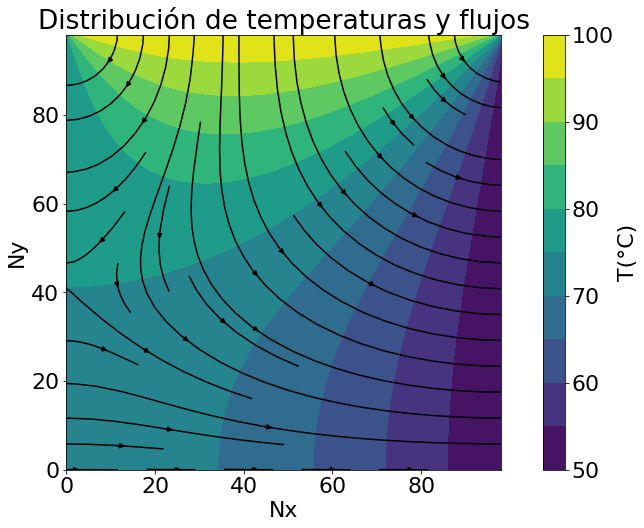

In [16]:
mapable = plt.contourf(T_matriz, levels=lvl)
plt.streamplot(X, Y, -Qx_matriz, -Qy_matriz, color='k', density=0.6)   # El (-) es por la ecuación de Fourier.
plt.gca().set_aspect('equal')
cbar = plt.colorbar(mapable)
cbar.set_label('T(°C)')
plt.title('Distribución de temperaturas y flujos')
plt.xlabel('Nx')
plt.ylabel('Ny')
plt.axis([0, Nx-2, 0, Ny-2])   # Sino me deja líneas en blanco, muy raro.
plt.show()

## Tiempo de cálculo en función del tamaño del sistema

In [17]:
# Defino vector "Ns" con valores entre 3 y 99, espaciados cada 6. Aquellos son los diferentes tamaños de sistema que evaluaré.
Ns = np.arange(3, 100, 6)

In [24]:
# Debido a que los tiempos de cálculo van como una exponencial, expreso "Ns" en escala logarítmica.
Ns = np.logspace(np.log10(3), 2, 10).astype(int)

<div style="background:#999900">podes hacer un poco mas de puntos </div>

In [27]:
# Debido a que los tiempos de cálculo van como una exponencial, expreso "Ns" en escala logarítmica.
Ns = np.logspace(np.log10(3), np.log10(120), 10).astype(int)

In [28]:
# Defino vector "ts" que almacenará el tiempo de cálculo asociado a cada tamaño de sistema guardado en "Ns".
ts = []

for Ni in Ns:
    chapa_i = chapa(Ni, Ni)
    M, b = chapa_i.makematrix(CC, TipoCC)
    t1 = time.time()
    T = np.linalg.solve(M, b)
    T_matriz = T.reshape(Ni, Ni)
    t2 = time.time()
    ts.append(t2-t1)

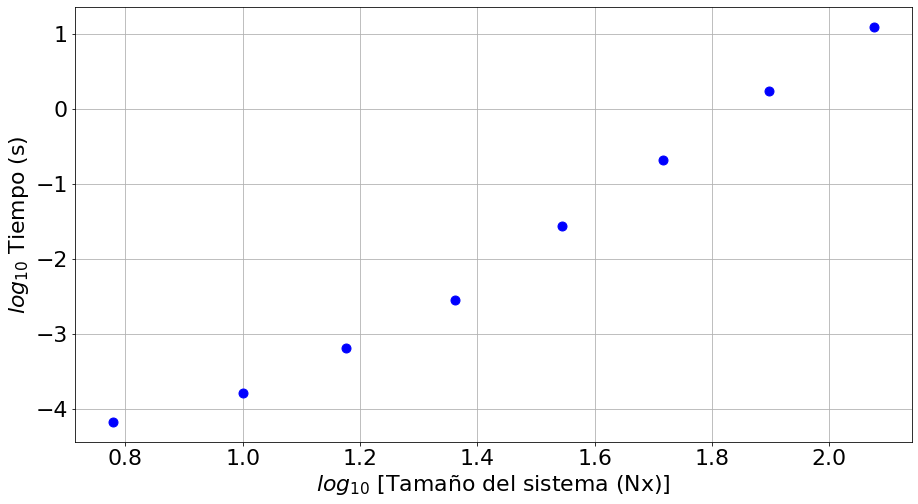

In [29]:
plt.plot(np.log10(Ns[2:]), np.log10(ts[2:]), 'ob', ms=9)
plt.xlabel('$log_{10}$ [Tamaño del sistema (Nx)]')
plt.ylabel('$log_{10}$ Tiempo (s)')
plt.grid('on')
#plt.axis([0, 100, -0.1, 7])
plt.show()

Y luego se puede ver la PENDIENTE, haciendo un ajuste lineal:

In [30]:
recta = np.polyfit(np.log10(Ns[2:]), np.log10(ts[2:]), 1)

In [31]:
func = np.poly1d(recta)

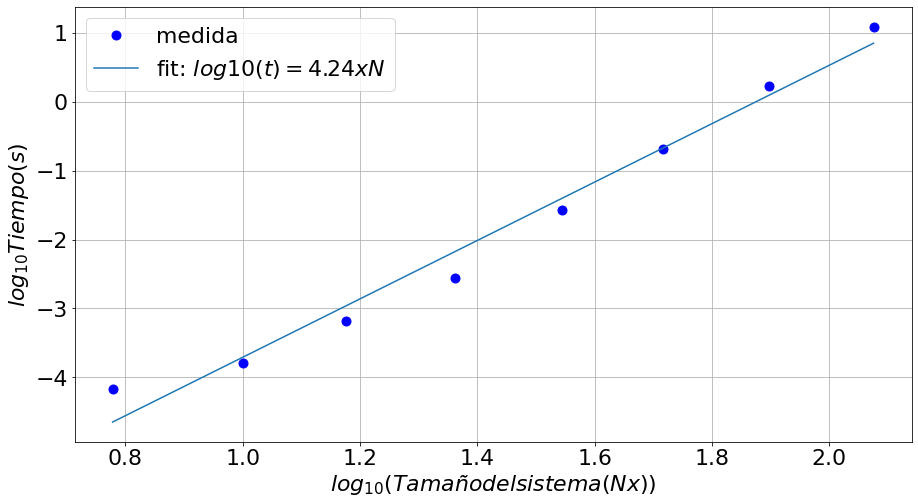

In [32]:
plt.plot(np.log10(Ns[2:]), np.log10(ts[2:]), 'ob', ms=9,label='medida')
plt.plot(np.log10(Ns[2:]), func(np.log10(Ns[2:])), label=f'fit: $log10(t) = {recta[0]:.2f}x N$')
plt.xlabel('$log_{10} ( Tamaño del sistema (Nx))$')
plt.ylabel('$log_{10} Tiempo (s)$')
plt.grid('on')
plt.legend()
#plt.axis([0, 100, -0.1, 7])
plt.show()

**COMENTARIO de @cucaszuban:** No llegué a responder en el pull request en su momento, pero lo hago aquí. Me resultó extraño ver que la pendiente dé 4,78 porque esperaba que dé un valor próximo a 3, ya que si por ejemplo uno duplica la cantidad de nodos ($N_1 = 2 N_0$) la consecuencia era que el tiempo de cálculo se multiplique por 8 ($t_1 = 8 t_0$), por lo que $t = N^3$. 

<div style="background:#999900">lo que pasa es que tu sistema es de tamaño $N_x^2$, por lo que la relación es en realidad $t\propto N_x^6$. Acá es un poco mejor porque la compu paraleliza la inversión</div>